In [35]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [111]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

In [36]:
def generate_circle_sample_data(r, n, sigma):
    """Generates circle data with random gaussian noise."""
    angles = np.random.uniform(low=0, high=2*np.pi, size=n)

    x_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)
    y_epsilon = np.random.normal(loc=0.0, scale=sigma, size=n)

    x = r*np.cos(angles) + x_epsilon
    y = r*np.sin(angles) + y_epsilon
    
    return x, y

def generate_concentric_circles_data(r_list, n_list, sigma_list):
    coordinates = [ 
        generate_circle_sample_data(r_list[i], n_list[i], sigma_list[i])
     for i in range(0, len(r_list))
    ]
    return coordinates

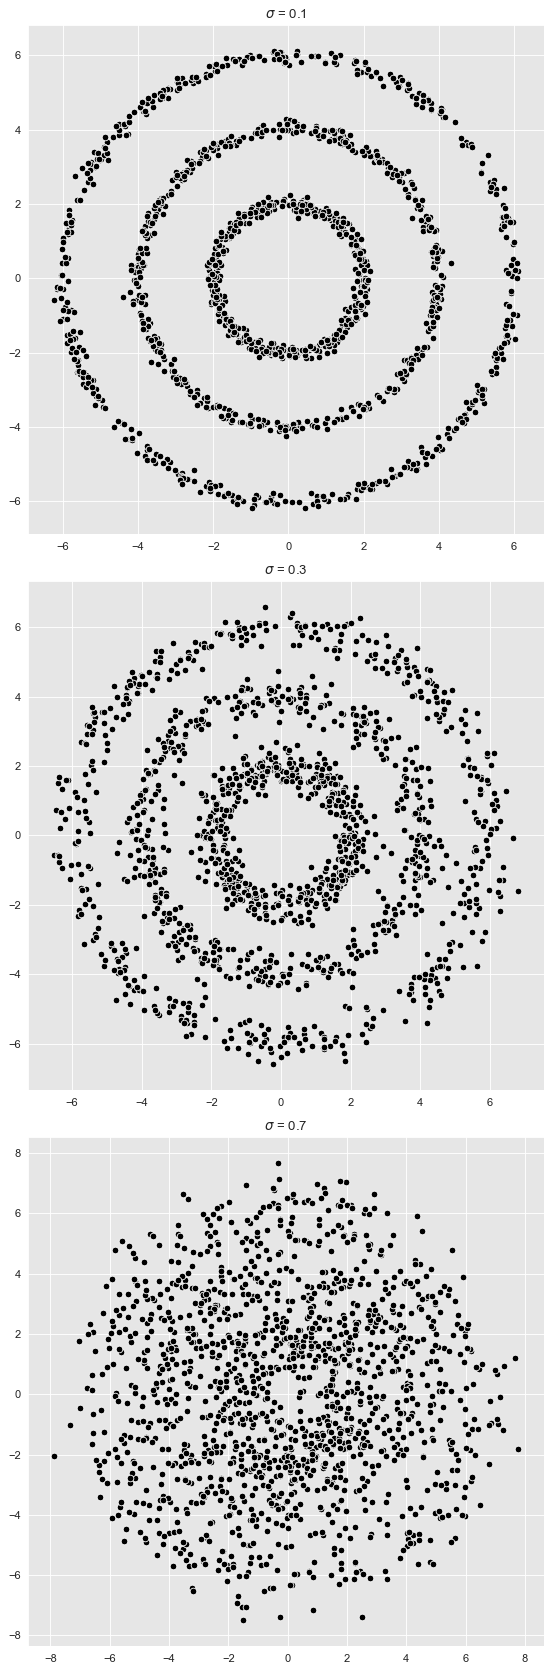

In [37]:
# Set global plot parameters. 
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 80

r_list =[2, 4, 6]
n = 500
n_list = [n]*3

sigmas = [0.1, 0.3, 0.7]

fig, axes = plt.subplots(3, 1, figsize=(7, 21))

for i, sigma in enumerate(sigmas):

    coordinates = generate_concentric_circles_data(r_list, n_list, [sigma]*len(r_list))
    
    ax =axes[i]
    
    for j in range(0, len(coordinates)):
    
        x, y = coordinates[j]
    
        sns.scatterplot(x=x, y=y, ax=ax, color='k')
        ax.set(title=f'$\sigma$ = {sigma}')

plt.tight_layout()

In [81]:
coordinates = generate_concentric_circles_data(r_list, n_list, [0.1]*len(r_list))

In [124]:
from functools import reduce

def data_frame_from_coordinates(coordinates): 
    
    data_df = reduce(
        lambda x, y: pd.concat([x, y], axis=0),  
        [pd.DataFrame({'x': c[0], 'y': c[1]}) for c in coordinates]
    )
    
    return data_df

In [125]:
data_df = data_frame_from_coordinates(coordinates)

data_df.shape

(1500, 2)

In [133]:
from sklearn.neighbors import kneighbors_graph

nn = 10

adjacency_matrix_s = kneighbors_graph(X=data_df, n_neighbors=nn, mode='connectivity')

In [142]:
from scipy import sparse
graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
graph_laplacian = graph_laplacian_s.toarray()

In [143]:
from scipy import linalg
eigenvals, eigenvcts = linalg.eig(graph_laplacian)

#eigenvals = np.real(eigenvals)

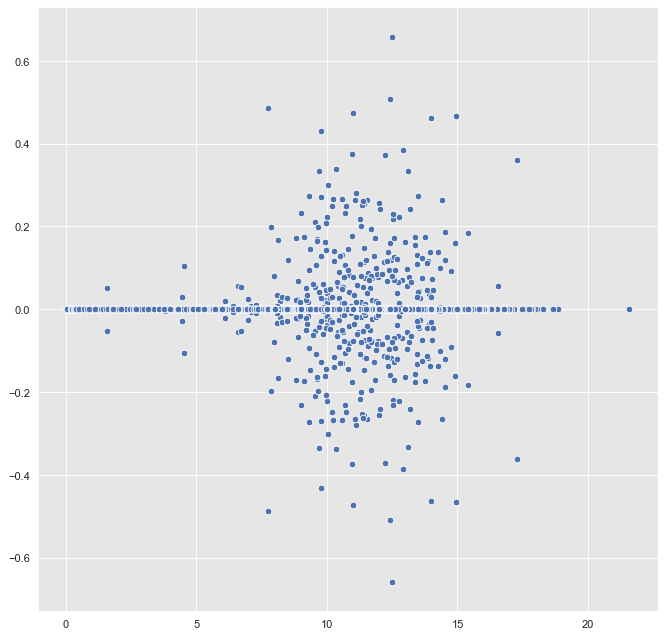

In [144]:
fig, ax = plt.subplots()

sns.scatterplot(x=np.real(eigenvals), y=np.imag(eigenvals), ax=ax)

In [44]:
#eigenvals, eigenvcts = sparse.linalg.eigs(A=graph_laplacian_s, k=200)

In [130]:
eigenvals_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_indices]

eigenvals_sorted[0:10]

array([-3.80861183e-15-6.20657516e-16j, -3.80861183e-15+6.20657516e-16j,
       -3.15225979e-15+0.00000000e+00j, -2.60767894e-15-6.30435356e-16j,
       -2.60767894e-15+6.30435356e-16j, -2.55060169e-15+0.00000000e+00j,
       -2.43000585e-15-6.10155175e-16j, -2.43000585e-15+6.10155175e-16j,
       -2.11116300e-15-1.45248440e-16j, -2.11116300e-15+1.45248440e-16j])

NotImplementedError: function is not implemented for this dtype: [how->mean,dtype->complex128]

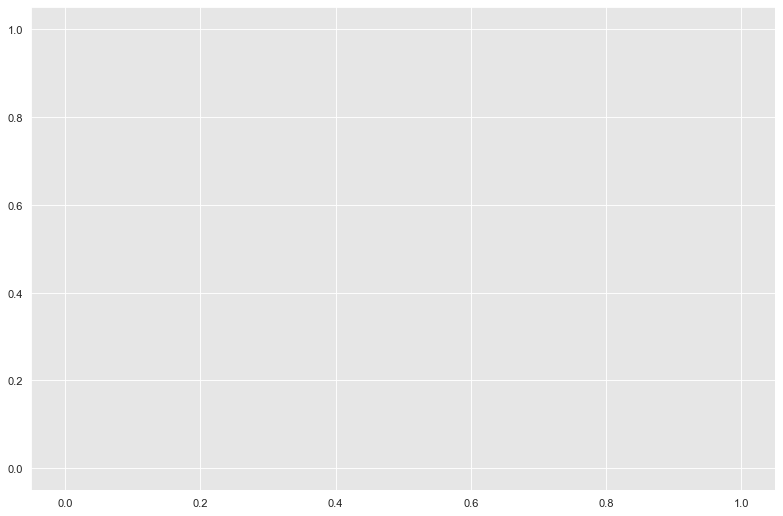

In [131]:
#eigenvals.sort()

fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(x=list(range(0, eigenvals_sorted.size)), y=eigenvals_sorted, ax=ax)

In [ ]:
iii = np.argwhere(abs(eigenvals) < 1e-6)

In [132]:
eigenvals[iii]

array([[0.        +0.j],
       [3.80193774+0.j],
       [3.        +0.j]])

In [50]:
eigenvcts[iii.squeeze(), :].shape

(3, 1500)

In [51]:
df = pd.DataFrame(eigenvcts[:, iii.squeeze()])

#df = pd.DataFrame(np.round(np.real(eigenvcts[eigenvals_indices[0:h]]), 5)).transpose()

df.columns = ['v_' + str(c) for c in df.columns]

df#.head()

,v_0,v_1,v_2
0,-0.043992+0.000000j,0.000000+0.000000j,0.000000+0.000000j
1,-0.030678+0.000000j,0.000000+0.000000j,0.000000+0.000000j
2,-0.066477+0.000000j,0.000000+0.000000j,0.000000+0.000000j
3,-0.036830+0.000000j,0.000000+0.000000j,0.000000+0.000000j
4,-0.020669+0.000000j,0.000000+0.000000j,0.000000+0.000000j
...,...,...,...
1495,0.000000+0.000000j,0.000000+0.000000j,-0.057902+0.000000j
1496,0.000000+0.000000j,0.000000+0.000000j,-0.030811+0.000000j
1497,0.000000+0.000000j,0.000000+0.000000j,-0.062378+0.000000j
1498,0.000000+0.000000j,0.000000+0.000000j,-0.025639+0.000000j


In [52]:
from sklearn.cluster import KMeans

inertias = []

k_candidates = range(1, 15)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(np.real(df.values))
    inertias.append(k_means.inertia_)

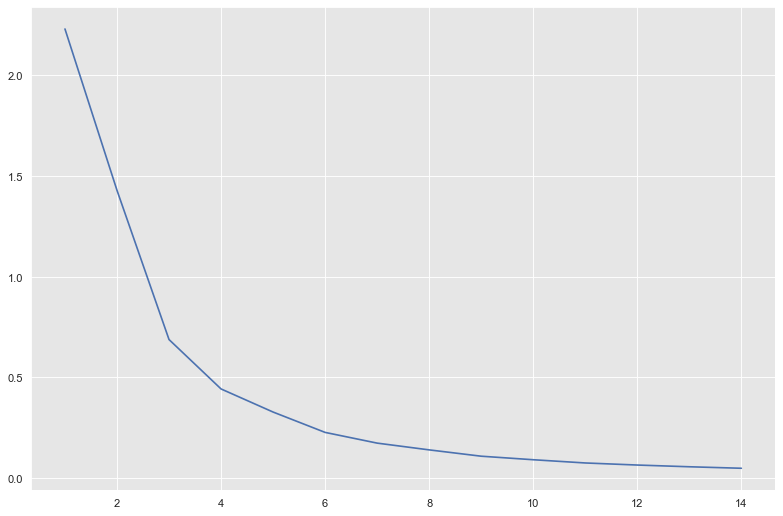

In [53]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=k_candidates, y = inertias, ax=ax)

In [54]:
k_means = KMeans(random_state=42, n_clusters=3)
k_means.fit(np.real(df.values))
cluster = k_means.predict(np.real(df.values))

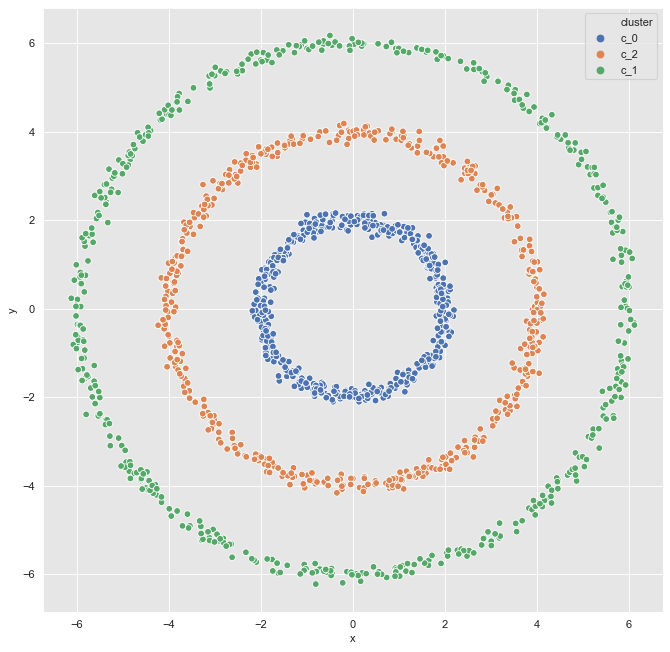

In [55]:
data_df['cluster'] = ['c_' + str(c) for c in cluster]

fig, ax = plt.subplots()

sns.scatterplot(x='x', y='y', data=data_df.query('cluster != "c_9"'), hue='cluster', ax=ax)
